### collapse data

In [36]:
import pandas, math
from collections import defaultdict
%matplotlib inline

In [40]:
fg_file = '../data/interim/EPIv6.eff.dbnsfp.anno.hHack.splitPfam.dat'
bg_file = '../data/interim/r1_no_tcga/exac.tidy.eff.dbnsfp.gt.anno.hHack.splitPfam.dat'
df_exac_pre = pandas.read_csv(bg_file, sep='\t')
max_exac_an = max(df_exac_pre['an'].values)

df_fg_pre = pandas.read_csv(fg_file, sep='\t')
max_fg = max([p+2*n for p,n in df_fg_pre[['pos_fam', 'neg_fam']].values])
df_exac = df_exac_pre[df_exac_pre['af_1kg_all'] < .01]
df_fg = df_fg_pre[df_fg_pre['af_1kg_all'] < .01]

# don't forget to add non-var counts
var = 'synonymous_variant'
cols = ['pfam', 'chrom', 'pos']
pfam_to_exac_pos = defaultdict(dict)
for pfam, chrom, pos in list(df_exac[df_exac.eff==var][cols].values):
    pfam_to_exac_pos[pfam][str(chrom) + ':' + str(pos)] = True
pfam_to_fg_pos = defaultdict(dict)
for pfam, chrom, pos in list(df_fg[df_fg.eff==var][cols].values):
    pfam_to_fg_pos[pfam][str(chrom) + ':' + str(pos)] = True

missing_exac_count = []
for pfam in pfam_to_fg_pos:
    if not pfam in pfam_to_exac_pos:
        ls = [pfam, len(pfam_to_fg_pos[pfam])]
        missing_exac_count.append(ls)
    else:
        miss_len = len( set(pfam_to_fg_pos[pfam]) - set(pfam_to_exac_pos[pfam]) )
        ls = [pfam, miss_len]
        missing_exac_count.append(ls)
missing_exac_df = pandas.DataFrame({'pfam':[x[0] for x in missing_exac_count],
                                    'miss_exac':[x[1] for x in missing_exac_count]})        
missing_fg_count = []
for pfam in pfam_to_exac_pos:
    if not pfam in pfam_to_fg_pos:
        ls = [pfam, len(pfam_to_exac_pos[pfam])]
        missing_fg_count.append(ls)
    else:
        miss_len = len( set(pfam_to_exac_pos[pfam]) - set(pfam_to_fg_pos[pfam]) )
        ls = [pfam, miss_len]
        missing_fg_count.append(ls)
missing_fg_df = pandas.DataFrame({'pfam':[x[0] for x in missing_fg_count],
                                  'miss_fg':[x[1] for x in missing_fg_count]})

missing_df = pandas.merge(missing_fg_df, missing_exac_df, on='pfam', how='outer').fillna(0)

#fg_pos = set([chrom + ':' + pos for chrom, pos in df_fg[df_fg.eff==var][cols].values])
#missing_exac_count = len(fg_pos) - len(exac_pos)

cols = ['ac', 'an']
g_exac = df_exac[df_exac.eff==var].groupby('pfam')[cols].sum().reset_index()
#g_exac.head()

fg_cols = ['pos_fam', 'neg_fam']
g_fg = df_fg[df_fg.eff==var].groupby('pfam')[fg_cols].sum().reset_index()
#g_fg.head()

m_pre = pandas.merge(g_fg, g_exac, on='pfam', how='outer').fillna(0)
m = pandas.merge(m_pre, missing_df, on='pfam', how='left')
print(max_exac_an, max_fg)
#m.head()

def calc_fg_neg(row, max_fg):
    return 2*row['neg_fam'] + max_fg*row['miss_fg'] + row['pos_fam']

def calc_bg_neg(row, max_exac):
    return row['an'] + max_exac*row['miss_exac']

m.loc[:, 'fg_tot'] = m.apply(lambda row: calc_fg_neg(row, max_fg), axis=1)
m.loc[:, 'bg_tot'] = m.apply(lambda row: calc_bg_neg(row, max_exac_an), axis=1)
m['fg_frac'] = (1+m['pos_fam']) / m['fg_tot']
m['fg_frac_log'] = m.apply(lambda row: math.log(row['fg_frac'], 2), axis=1)
m['bg_frac'] = (1+m['ac']) / m['bg_tot']
m['bg_frac_log'] = m.apply(lambda row: math.log(row['bg_frac'], 2), axis=1)
m['fg_other'] = m['fg_tot'] - m['pos_fam']
m['bg_other'] = m['bg_tot'] - m['ac']
m.head()

/opt/conda/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


106210 17165


,pfam,pos_fam,neg_fam,ac,an,miss_fg,miss_exac,fg_tot,bg_tot,fg_frac,fg_frac_log,bg_frac,bg_frac_log,fg_other,bg_other
0,Aldedh:185,1.0,7302.0,102,2230410,4,0.0,83265.0,2230410.0,0.000024,-15.345423,0.000046,-14.402377,83264.0,2230308.0
1,Aldedh:194,1.0,7302.0,33,2228994,6,0.0,117595.0,2228994.0,0.000017,-15.843467,0.000015,-16.000498,117594.0,2228961.0
2,Asp:20,2.0,8543.0,201,2442798,21,1.0,377553.0,2549008.0,0.000008,-16.941357,0.000079,-13.623293,377551.0,2548807.0
3,CD36:17,1.0,3914.0,18,1486940,7,1.0,127984.0,1593150.0,0.000016,-15.965604,0.000012,-16.355523,127983.0,1593132.0
4,CD36:23,1.0,3914.0,28,1061960,4,0.0,76489.0,1061960.0,0.000026,-15.222965,0.000027,-15.160317,76488.0,1061932.0


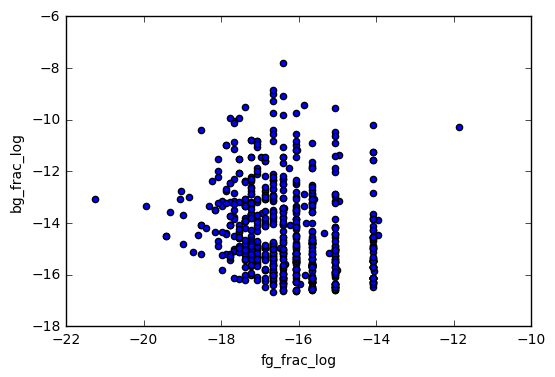

In [41]:
m.plot.scatter('fg_frac_log', 'bg_frac_log')

In [42]:
df_fg[df_fg.eff==var].head()

,chrom,pos,ref,alt,clin_class,pfam,af_1kg_all,eff,pos_fam,neg_fam
228,1,160105771,G,A,LIKELY_BENIGN,none,0.0,synonymous_variant,1,5083
286,11,794868,G,A,LIKELY_BENIGN,Mito_carr:59,0.0,synonymous_variant,1,7165
306,11,1778697,G,A,VUS,Asp:20,0.0,synonymous_variant,2,8543
386,11,6640011,T,C,PATHOGENIC,none,0.0,synonymous_variant,1,8544
405,11,71903298,A,C,LIKELY_BENIGN,Folate_rec:8,0.0,synonymous_variant,1,6024


In [43]:
m[['fg_frac', 'bg_frac']].corr()

,fg_frac,bg_frac
fg_frac,1.000000,-0.026476
bg_frac,-0.026476,1.000000
